In [1]:
import jax
from position2 import Position2
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.interpolate
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import functools
import jax.random
from flax.optim.adam import Adam

ROS is not sourced. To enable ROS features, please source it


# Load dataset

In [2]:
# datafile = "/media/mikhail/Data3T/slam_benchmark/intel.clf"
DATAFILE = "/home/mikhail/Downloads/intel.gfs(4).log" # Corrected intel map
# datafile = "/home/mikhail/Downloads/intel.gfs.log"

In [3]:
@dataclass(frozen=True)
class LaserData(object):
    ranges: np.array
    angles: np.array
    timestamp: float
    odometry_position: Position2
        
    def as_points(self):
        mask = self.ranges < 10
        x = self.ranges[mask] * np.cos(self.angles[mask])
        y = self.ranges[mask] * np.sin(self.angles[mask])
        return np.stack([x, y], axis=1)

    def as_points_in_odometry_frame(self):
        points = self.as_points()
        return self.odometry_position.apply(points)

In [4]:
LASER_DATA_LIST = []
with open(DATAFILE, "r") as fd:
    for line in fd.readlines():
        line = line.strip()
        tokens = line.split(' ')
        if len(tokens) <= 180:
            continue
        num_scans = int(tokens[1])
        ranges = np.array([float(r) for r in tokens[2:(num_scans + 2)]])
        angles = np.linspace(-90.0 / 180.0 * np.pi, 90.0 / 180.0 * np.pi, num_scans + 1)[:-1]
        timestamp = float(tokens[(num_scans + 8)])
        odom_x, odom_y, odom_theta = [float(r) for r in tokens[(num_scans + 2):(num_scans + 5)]]
        position = Position2(odom_x, odom_y, odom_theta)
        LASER_DATA_LIST.append(LaserData(ranges=ranges, angles=angles, timestamp=timestamp, odometry_position=
                                        position))

In [5]:
def show_points(laser_data_list, indeces):
    all_points = []
    for i in range(len(indeces)):
        laser_data = laser_data_list[indeces[i]]
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")

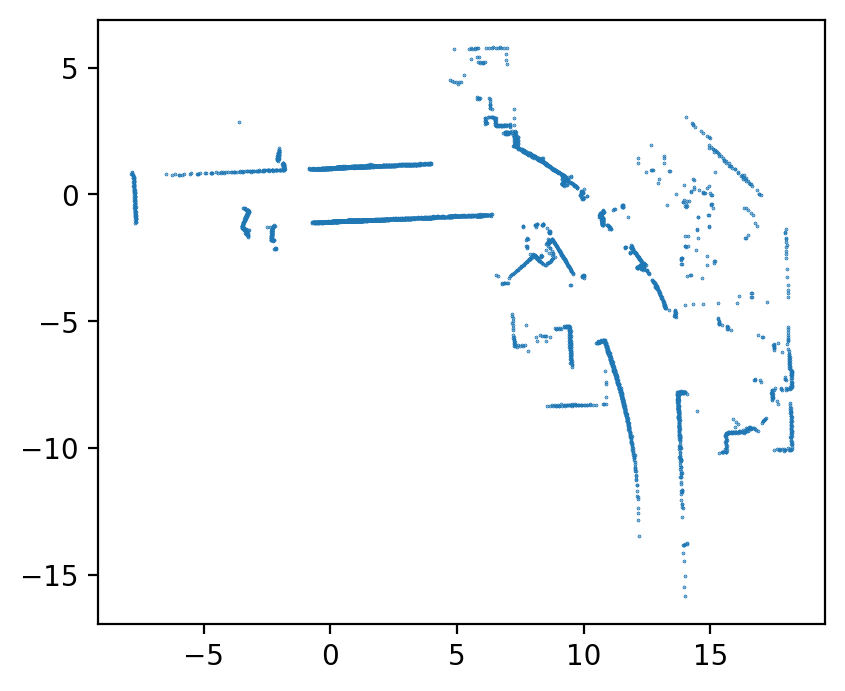

In [6]:
laser_data_list = LASER_DATA_LIST
plt.figure(dpi=200)
all_points = []
for laser_data in laser_data_list[:30]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
plt.gca().set_aspect('equal')

# Rendering

In [205]:
class NFModel(nn.Module):
    mean: float
    sigma: float

    @nn.compact
    def __call__(self, x):
        x = (x - self.mean) / self.sigma
        x = nn.Dense(256, use_bias=True)(x)      
        x = jnp.concatenate([jnp.sin(x[:, :128]), jnp.cos(x[:, 128:])], axis=1)
        x1 = x
        x1 = nn.Dense(256)(x1)
        x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]


In [206]:
def plot_model_heatmap(model, variables, bounds, vmax=None, grid_shape=(100, 100)):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], 100), 
                                  jnp.linspace(bounds[2], bounds[3], 100))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = jax.nn.softplus(model.apply(variables, grid))
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(100, 100)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=0, vmax=None)
    plt.gca().set_aspect('equal')

In [208]:
MODEL = NFModel(0, 0.2)
batch = jnp.ones([10, 2])
VARIABLES = MODEL.init(jax.random.PRNGKey(1), batch)
output = MODEL.apply(VARIABLES, batch)

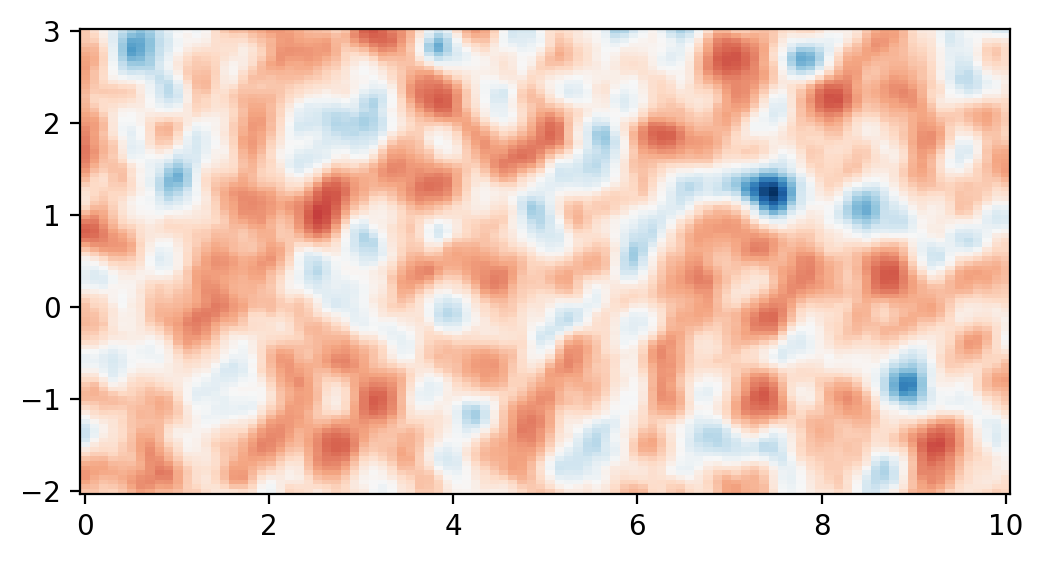

In [219]:
plt.figure(dpi=200)
k = 1
plot_model_heatmap(MODEL, VARIABLES, (0 * k, 10 * k, -2 * k, 3 * k))

# Space hashing

In [222]:
@jax.jit
def hashfunction(x, T):
    pi1 = 1
    pi2 = 19349663
    pi3 = 83492791
    result = jnp.bitwise_xor(x[:, 0] * pi1, x[:, 1] * pi2)
    return result % T

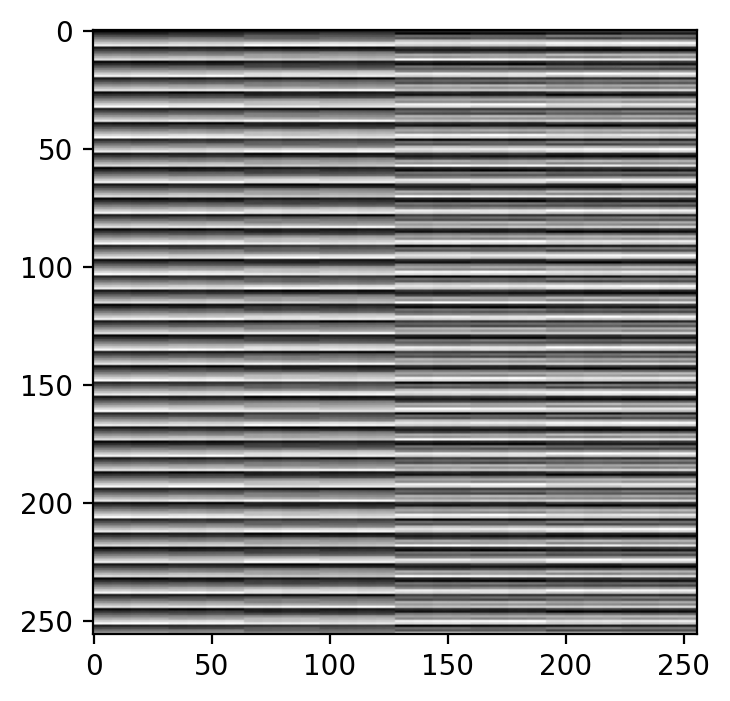

In [223]:
x, y = jnp.meshgrid(jnp.arange(256), jnp.arange(256))
points = jnp.stack([x, y], axis=2)
values = hashfunction(points.reshape(-1, 2), 1024).reshape(256, 256)
plt.figure(dpi=200)
plt.imshow(values, cmap="gray")

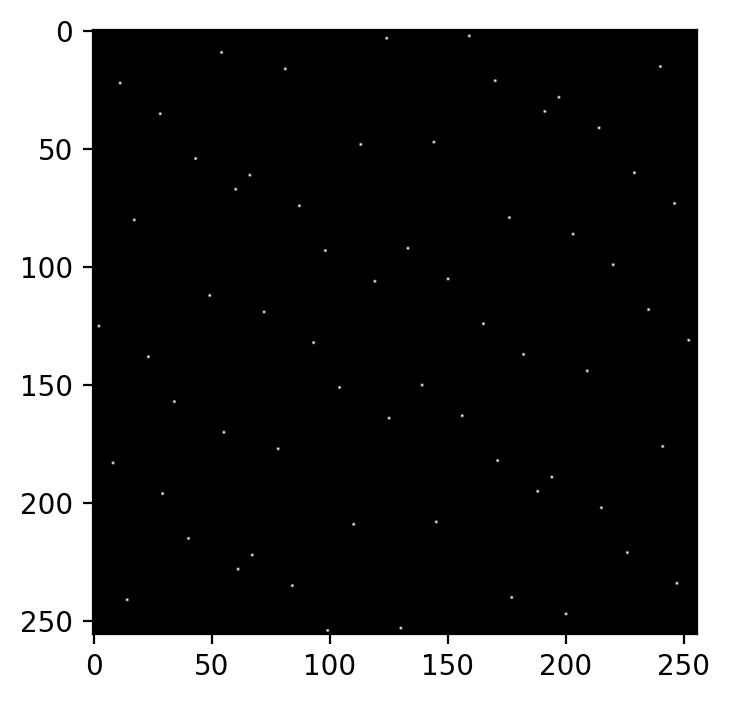

In [224]:
random_reindex = np.random.choice(np.arange(1024), 1024, replace=False)
random_reindex = jnp.array(random_reindex)
plt.figure(dpi=200)
plt.imshow(random_reindex[values] == 30, cmap="gray")

In [247]:
class MLPModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256, use_bias=True)(x)
        x1 = x
        x1 = nn.Dense(256)(x1)
        x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
#         x = x1
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]

In [315]:
@jax.jit
def bilinear_interpolation(deltas, values0, values1, values2, values3):
    f1 = values0 * (1 - deltas[:, 0])[:, None] + values2 * deltas[:, 0][:, None]
    f2 = values2 * (1 - deltas[:, 0])[:, None] + values3 * deltas[:, 0][:, None]
    return f1 * (1 - deltas[:, 1])[:, None] + f2 * deltas[:, 1][:, None]

@jax.jit
def calculate_layer_embeddings(hashtable, points, resolution, origin, T, rotation):
    points = ((points - origin) / resolution)
    x = jnp.cos(rotation) * points[:, 0] - jnp.sin(rotation) * points[:, 1]
    y = jnp.sin(rotation) * points[:, 0] + jnp.cos(rotation) * points[:, 1]
    points = jnp.stack([x, y], axis=1)
    cells = jnp.array(points // 1, jnp.int32)
    deltas = points % 1
    values0 = hashtable[hashfunction(cells, T)]
    values1 = hashtable[hashfunction(cells + jnp.array([1, 0]), T)]
    values2 = hashtable[hashfunction(cells + jnp.array([0, 1]), T)]
    values3 = hashtable[hashfunction(cells + jnp.array([1, 1]), T)]
    return bilinear_interpolation(deltas, values0, values1, values2, values3)

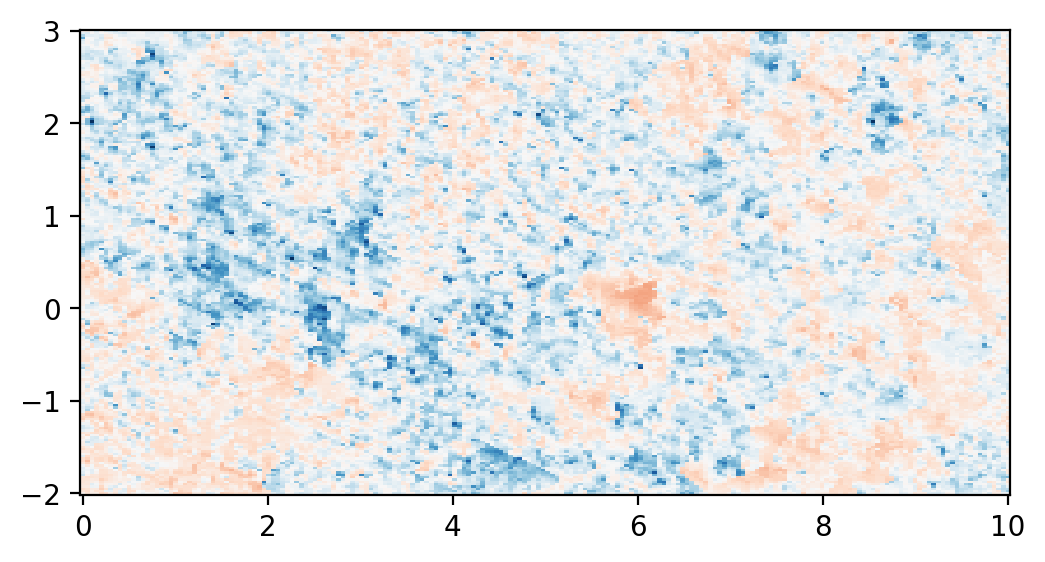

In [326]:
plt.figure(dpi=200)
L = 5
T = 128
F = 2
hashtable = jax.random.normal(jax.random.PRNGKey(1), (L, T, F))
resolutions = 2 ** jnp.linspace(-4, 3, L)
origins = jnp.zeros(2) + jax.random.normal(jax.random.PRNGKey(2), (L, 2))
rotations = jax.random.uniform(jax.random.PRNGKey(2), (L,)) * 2 * np.pi
k = 1
bounds = (0 * k, 10 * k, -2 * k, 3 * k)
grid_shape=(200, 200)

model = MLPModel()
batch = jnp.ones([10, F * L])
variables = model.init(jax.random.PRNGKey(1), batch)
output = model.apply(variables, batch)
map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=resolutions,
                     origins=origins, rotations=rotations)

grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], grid_shape[0]), 
                              jnp.linspace(bounds[2], bounds[3], grid_shape[1]))
grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)

obstacle_probabilites = calculate_densities(grid, map_model, model)
obstacle_probabilites = np.array(obstacle_probabilites).reshape(*grid_shape)
grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                    vmin=0, vmax=None)
plt.gca().set_aspect('equal')

# Train hashtabel

In [307]:
import flax
import jax_dataclasses as jdc

In [308]:
@jdc.pytree_dataclass
class MapModel(object):
    hashtable: jnp.array
    variables: flax.core.frozen_dict.FrozenDict
    resolutions: jnp.array
    origins: jnp.array
    rotations: jnp.array
        
@dataclass(frozen=True)
class ModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    bins_count: int
    density_scale: float
    variance_weight: float
    depth_delta: float = field(init=False)
    def __post_init__(self):
        self.depth_delta = (self.maximal_depth - self.minimal_depth) / self.bins_count

In [323]:
@functools.partial(jax.jit, static_argnums=2)
def calculate_densities(points: jnp.array, map_model: MapModel, model: MLPModel):
    embeddings = []
    for i in range(map_model.hashtable.shape[0]):
        embedding = calculate_layer_embeddings(map_model.hashtable[i], 
                                               points, 
                                               map_model.resolutions[i], 
                                               map_model.origins[i], 
                                               map_model.hashtable.shape[1], 
                                               map_model.rotations[i])
        embeddings.append(embedding)
    embedding = jnp.concatenate(embeddings, axis=1)
    return jax.nn.softplus(model.apply(map_model.variables, embedding))

In [268]:
@jax.jit
def calculate_weights(densities, depth_deltas):
    mis_probability = jnp.exp(-densities * depth_deltas)
    hit_probability = 1 - mis_probability
    mis_probability = jnp.concatenate([jnp.ones(1), mis_probability])
    hit_probability = jnp.concatenate([hit_probability, jnp.ones(1)])
    cumproduct = jnp.cumprod(mis_probability)
    weights = cumproduct * hit_probability
    return weights

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins(learning_data, parameters):
    depths = jnp.linspace(parameters.minimal_depth, parameters.maximal_depth, parameters.bins_count + 1)[:-1]
    depths = depths + parameters.depth_delta * learning_state.uniform
    return jnp.concatenate([jnp.full([depths.shape[0], 1], parameters.minimal_depth), 
                            depths, 
                            jnp.full([depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@jax.jit
def transform_points(points, x, y, angle):
    x = x[..., None]
    y = y[..., None]
    angle = angle[..., None]
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)


def calculate_points(depths, angles, angle_deltas):
    x = depths * jnp.cos(angles[..., None] + angle_deltas)
    y = depths * jnp.sin(angles[..., None] + angle_deltas)
    return jnp.stack([x, y], axis=-1)
    
@functools.partial(jax.jit, static_argnums=6)
def loss_function(map_model, position, data, config)
def loss_function(variables, position, truth_depths, angles, uniform, angle_deltas, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles, angle_deltas)
    points = transform_points(points, position[0], position[1], position[2]).reshape(-1, 2)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    return jnp.mean((truth_depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance + 1e-4) +
                   config.variance_weight * predicted_variance)

SyntaxError: invalid syntax (2019612849.py, line 35)